In [2]:
%matplotlib inline
import pandas as pd
import geopandas as gp
import numpy as np
import os

from shapely.geometry import Point
from geopandas.tools import sjoin

PARQA = os.getenv('PARQA')

In [3]:
def toGeoDataFrame(df, lat='lat',lon='lon'):
    '''dataframe to geodataframe'''
    df[lat].replace(0, np.nan)
    df[lon].replace(0, np.nan)
    df = df[pd.notnull(df[lat])]

    df['geometry'] = df.apply(lambda z: Point(z[lon], z[lat]), axis=1)
    df = gp.GeoDataFrame(df)
    df.crs = {'init': 'epsg:4326', 'no_defs': True}
    return df

In [4]:
df = pd.read_csv(PARQA + 'data/DPR_property/recr_centers.csv', index_col=0, encoding='utf-8')

In [39]:
from geopy.geocoders import GoogleV3#GeocoderDotUS #GoogleV3 #Nominatim
# geolocator = Nominatim()
geolocator = GoogleV3()

def geocode(x, geolocator):
    location = geolocator.geocode(x)
    if location:
        return (location.latitude, location.longitude)
    else:
        print 'failed to find:',x
        return (None,None)

In [40]:
def geocodeDF(df, adress, add=', NYC'):
    '''geolocate data'''
    df['geo'] = df[adress].apply(lambda x: geocode(x+add, geolocator))
    df['lat'] = df['geo'].apply(lambda x:x[0])
    df['lon'] = df['geo'].apply(lambda x:x[1])
    df = df.drop(['geo'],axis=1)
    return df

In [41]:
df = geocodeDF(df,'ADDRESS')

In [43]:
df.head(2)

,ADDRESS,BOROUGH,CENTER_MANAGER,CITY,DEPUTY_MANAGER,FAX,NAME,PHONE,PHONE_B,STATE,ZIP,cost_description,cost_free,description,message,lat,lon
0,Livonia Ave between Hopkinson & Amboy streets,NaN,NaN,Brooklyn,NaN,NaN,Betsy Head Field House,(718) 257-1636,NaN,NY,11212,NaN,0,NaN,NaN,40.534857,-74.184137
1,776 Lorimer Street,NaN,Seamus Moloney,Brooklyn,"Jeff Cooper, Tom Beaver",(718) 218-2390,McCarren Play Center,(718) 218-2380,NaN,NY,11222,NaN,0,"<p class=""alert alert-success"">Did you know ma...",NaN,40.720079,-73.949511


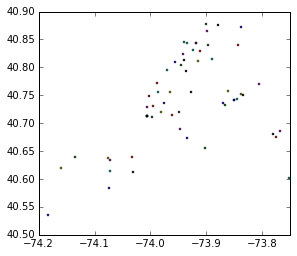

In [44]:
df = toGeoDataFrame(df)
df.plot()

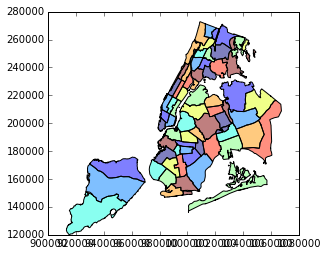

In [45]:
pDistricts = gp.read_file(PARQA + 'data/SHP/Park_Districts/ParkDistrict.shp')
pD = pDistricts[['SYSTEM','geometry']]
pD.plot()

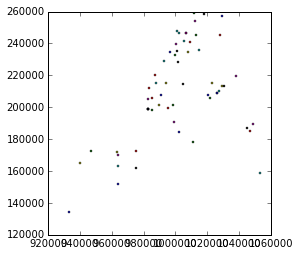

In [46]:
df = df.to_crs(pDistricts.crs)
df.plot()

In [47]:
dfD = sjoin(df, pD, how="left").rename(columns={'SYSTEM':'parkDistrict'}).to_crs(epsg=4326)

In [48]:
def writeGeoJson(gdf,path):
    '''writes df as json'''
    with open(path,'w') as jsFile:
        jsFile.write(gdf.to_json())

In [49]:
writeGeoJson(dfD, PARQA +'data/DPR_property/csv_ll_pD/recr_c_pd_ll.geojson')